In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from tensorflow.keras.callbacks import CSVLogger
import tensorflow.keras.backend as K
import zipfile

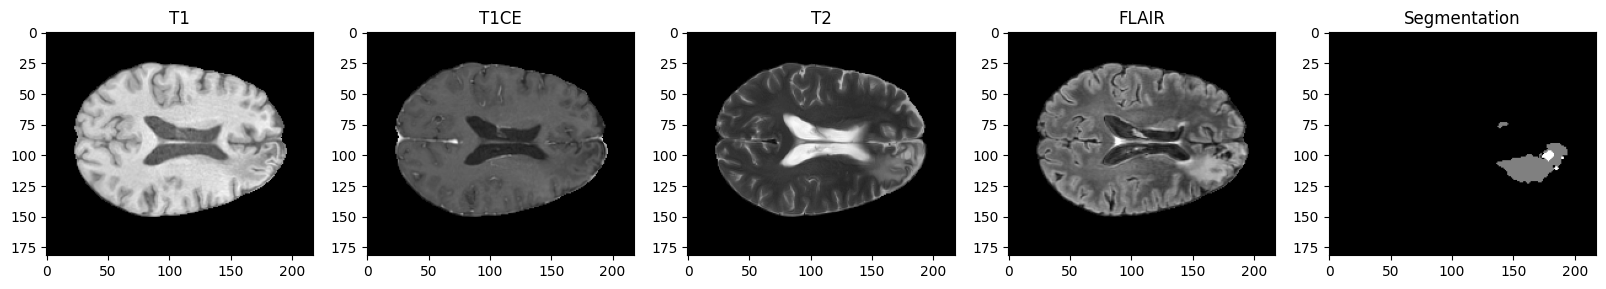

In [5]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = 'GLIOMA/BraTS-GLI-00006-101/BraTS-GLI-00006-101-'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1n.nii.gz')
t1ce_img=nib.load(sample_path + 't1c.nii.gz')
t2_img=nib.load(sample_path + 't2w.nii.gz')
flair_img=nib.load(sample_path + 't2f.nii.gz')
seg_img=nib.load(sample_path + 'seg.nii.gz')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

In [6]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(182, 218, 182)
(182, 218, 182)


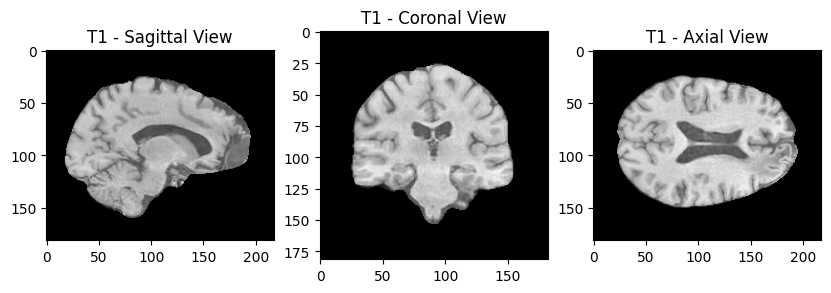

In [7]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

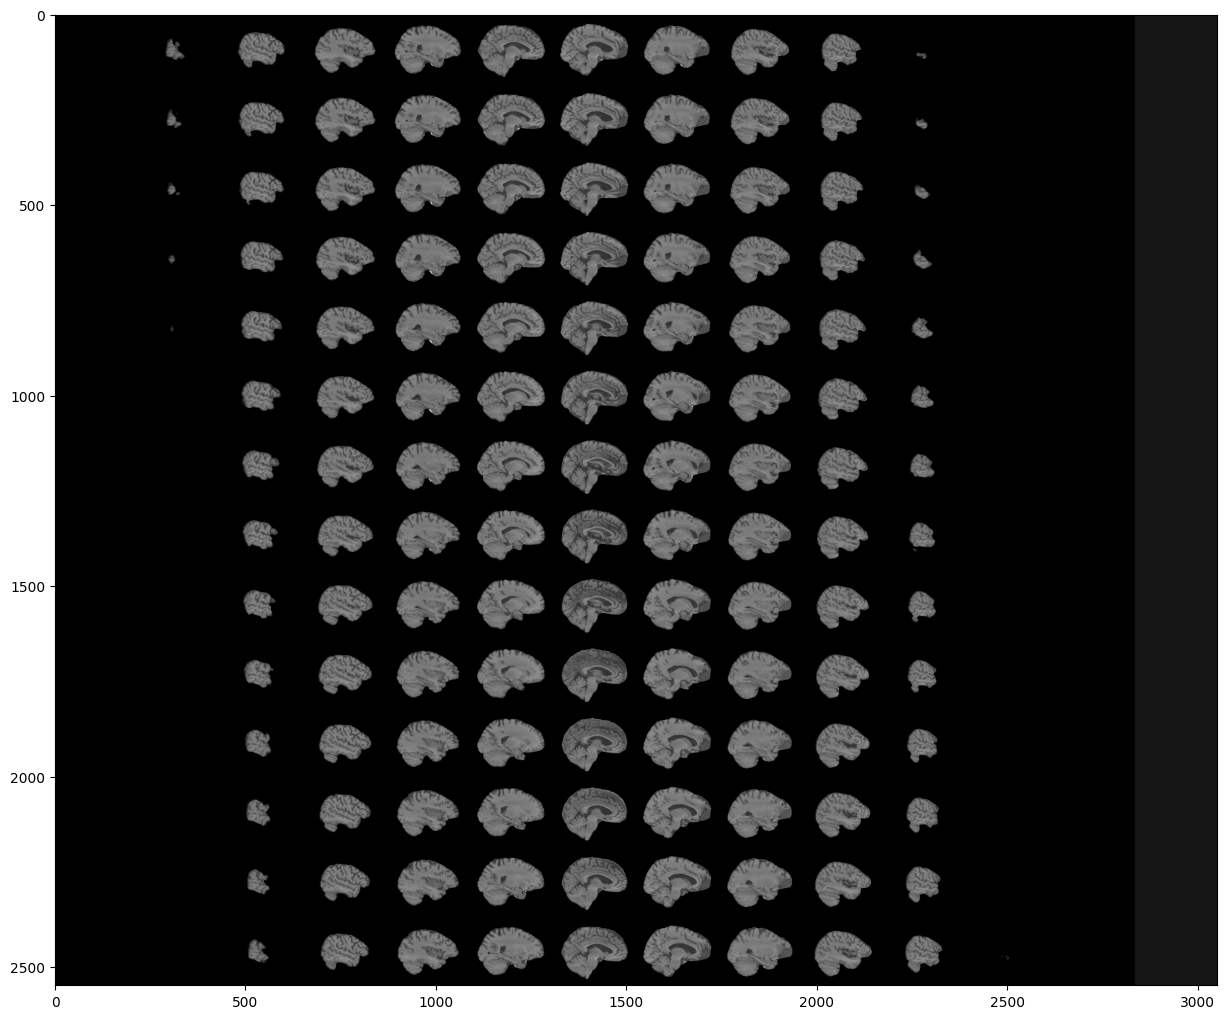

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

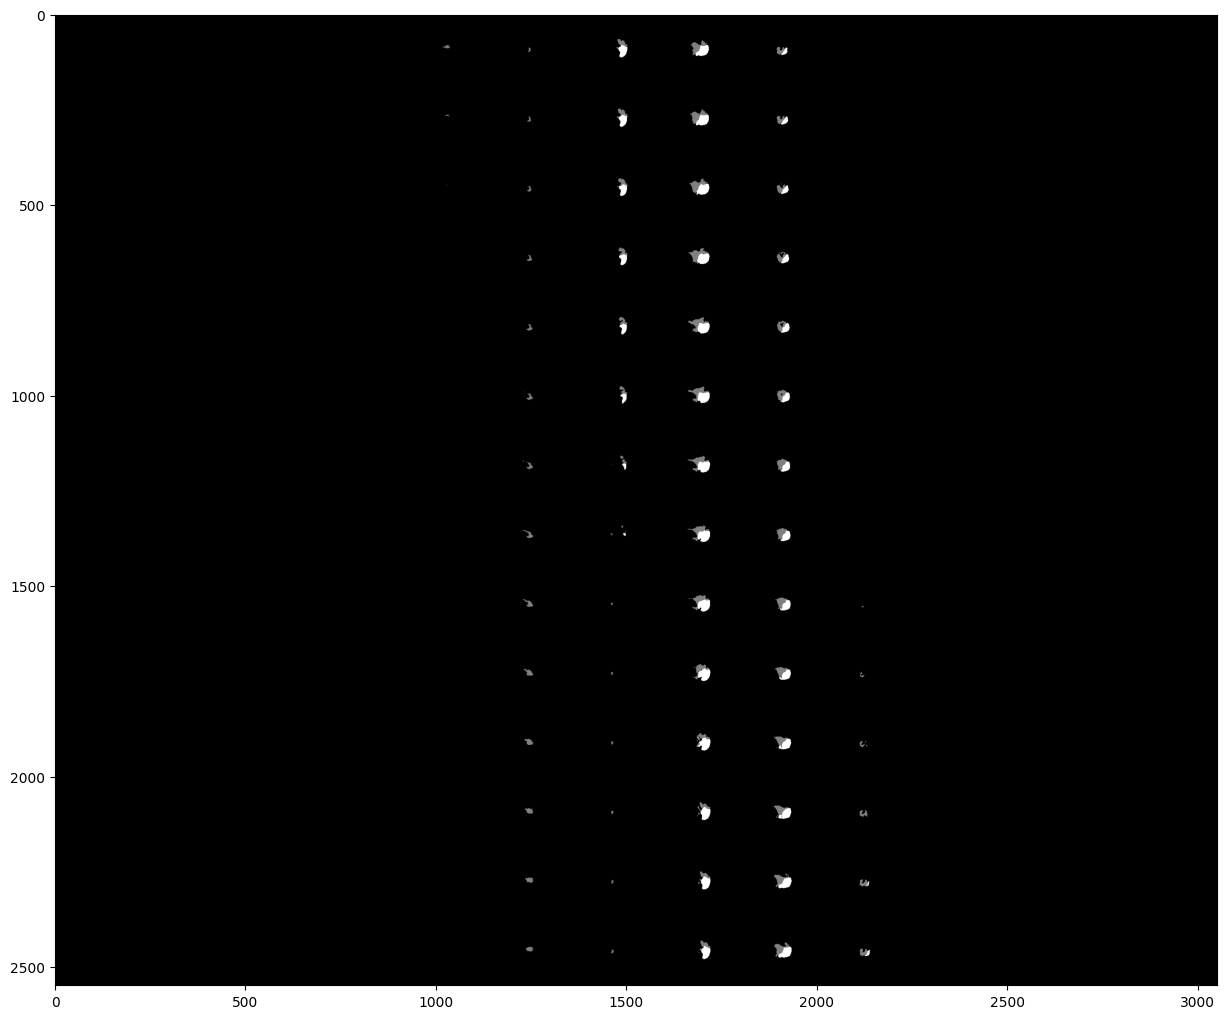

In [9]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

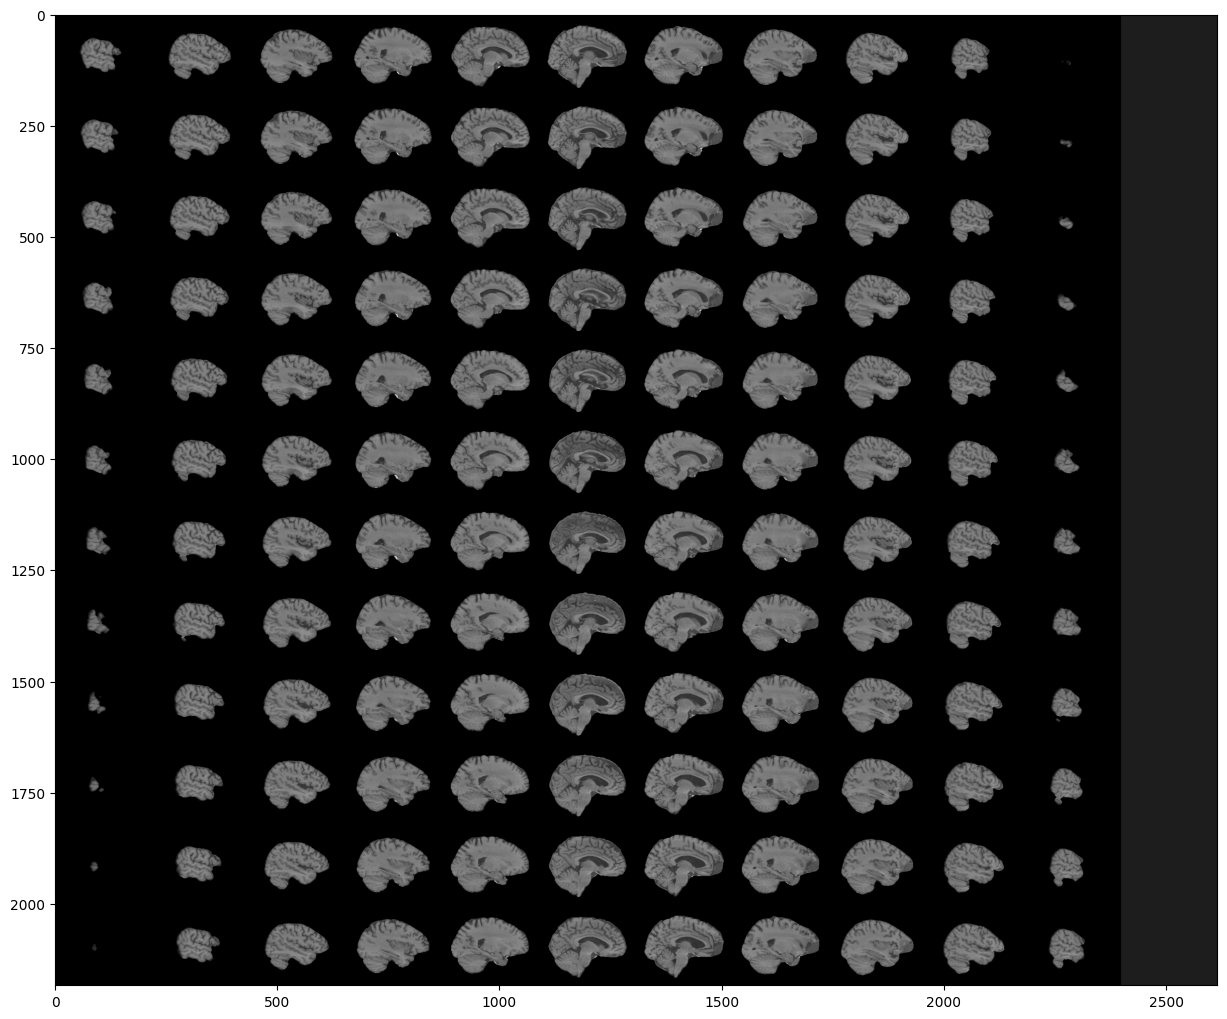

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[23:155,:,:]), 90, resize=True), cmap ='gray')

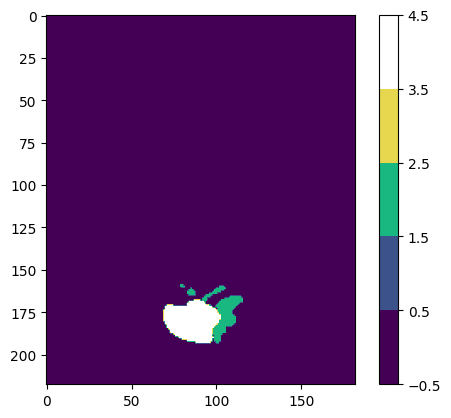

In [17]:
# Plot a segmantation
some_seg_img = nib.load("GLIOMA/BraTS-GLI-00006-101/BraTS-GLI-00006-101-seg.nii.gz").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f',"#ffffff"])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5,4.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [26]:
data_path = "GLIOMA/"
seg_samples = [os.path.join(data_path, sample, f"{sample}-seg.nii.gz") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 5
Values: [0. 1. 2. 3. 4.]


In [27]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[7183794   18747   18491]


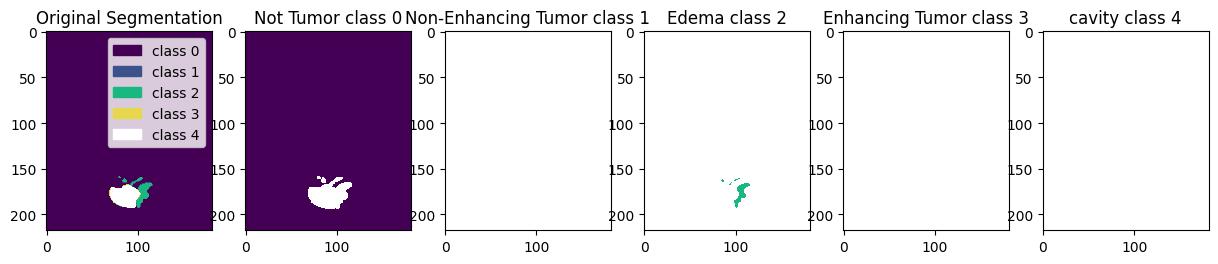

In [28]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 3] = np.nan
# Isolation of class 4
seg_4 = some_seg_img.copy()
seg_4[seg_4 != 4] = np.nan
# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 6, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')
axs3[5].imshow(seg_4[100,:,:], cmap=cmap, norm=norm)
axs3[5].set_title('cavity class 4')

plt.show()

In [29]:
# Define selected slices range
VOLUME_START_AT = 23
VOLUME_SLICES = 132

In [30]:
# Specify path of our BraTS2020 directory
data_path = "GLIOMA/"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 1350


In [31]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 918
Validation length: 270
Test length: 162


In [42]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 182, 218))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '-t1c.nii.gz'
            flair_path = sample_path + '-t2f.nii.gz'
            seg_path = sample_path + '-seg.nii.gz'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==3] = 3
        mask = tensorflow.one_hot(y, 5)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [43]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(5, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [44]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 5
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [45]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=5), dice_coef, precision, sensitivity, specificity] )

In [46]:
callbacks = [


    CSVLogger('training.log', separator=',', append=False)
]

In [49]:
model.fit(training_generator,
          epochs=150,
          batch_size=128,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/150
  2/918 [..............................] - ETA: 4:13:40 - loss: 0.0709 - accuracy: 0.9838 - mean_io_u_2: 0.4200 - dice_coef: 0.2142 - precision: 0.9835 - sensitivity: 0.9836 - specificity: 0.9959

KeyboardInterrupt: 